<a href="https://colab.research.google.com/github/dhanush26/RecomSys/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
%matplotlib inline

## 2. Preprocessing 

In [4]:

image_directory='/content/drive/MyDrive/archive (4)/'

no_tumor_images=os.listdir(image_directory+ 'no/')
yes_tumor_images=os.listdir(image_directory+ 'yes/')
dataset=[]
label=[]
INPUT_SIZE=64

# Resizing and shaping the images

In [5]:
#loop over each image in each category
for i , image_name in enumerate(no_tumor_images):
    #read the image if its extension is .jpg
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'no/'+image_name)
        image=Image.fromarray(image,'RGB')
        #resize the image
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        #append image arry in dataset list and its label in label list
        dataset.append(np.array(image))
        label.append(0)
# same for yes images
for i , image_name in enumerate(yes_tumor_images):
    if(image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_directory+'yes/'+image_name)
        image=Image.fromarray(image, 'RGB')
        image=image.resize((INPUT_SIZE,INPUT_SIZE))
        dataset.append(np.array(image))
        label.append(1)

dataset=np.array(dataset)
label=np.array(label)


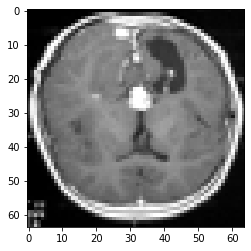

In [6]:
plt.imshow(dataset[2800])

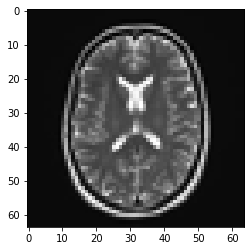

In [7]:
plt.imshow(dataset[21])

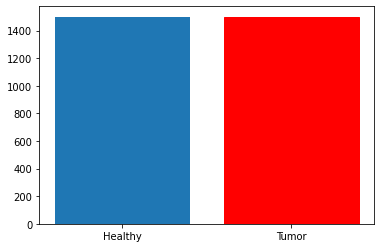

In [8]:
from collections import Counter 
c = Counter(label)
c["Healthy"] = c[0]
del c[0]
c['Tumor'] = c[1]
del c[1]
plot=plt.bar(c.keys(), c.values())
plot[1].set_color('r')

plt.savefig('DataDistribution.png')

# Enhancement and Edge Detection

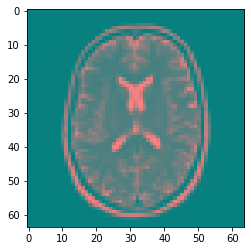

In [9]:
# convert RGB  to LAB
Healthy_image = cv2.cvtColor(dataset[21],cv2.COLOR_BGR2LAB)

l,a,b = cv2.split(Healthy_image)
plt.imshow(Healthy_image)
plt.show()

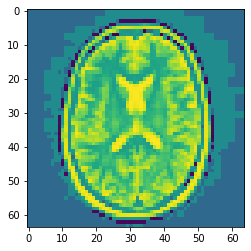

In [10]:
# apply equalization histogram to perceptual lightness (L)
equ1= cv2.equalizeHist(l)
plt.imshow(equ1)
plt.show()

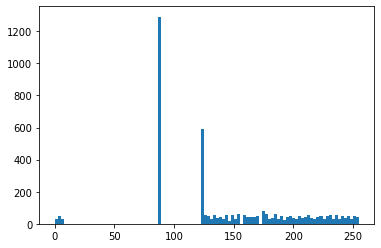

In [11]:
# plot equalization hist
plt.hist(equ1.flat, bins=100, range=(0,255))
plt.show()

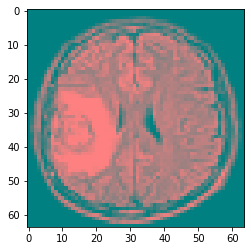

In [12]:
Tumor = cv2.cvtColor(dataset[2000],cv2.COLOR_BGR2LAB)
l,a,b = cv2.split(Tumor)
plt.imshow(Tumor)
plt.show()

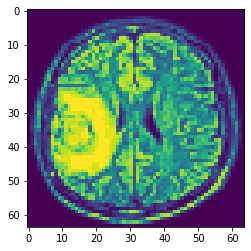

In [13]:
equ = cv2.equalizeHist(l)
plt.imshow(equ)
plt.show()

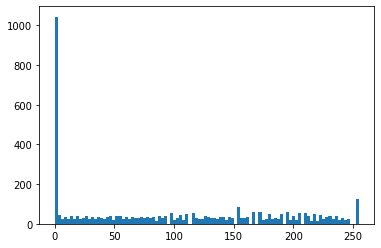

In [14]:
plt.hist(equ.flat, bins=100, range=(0,255))
plt.show()

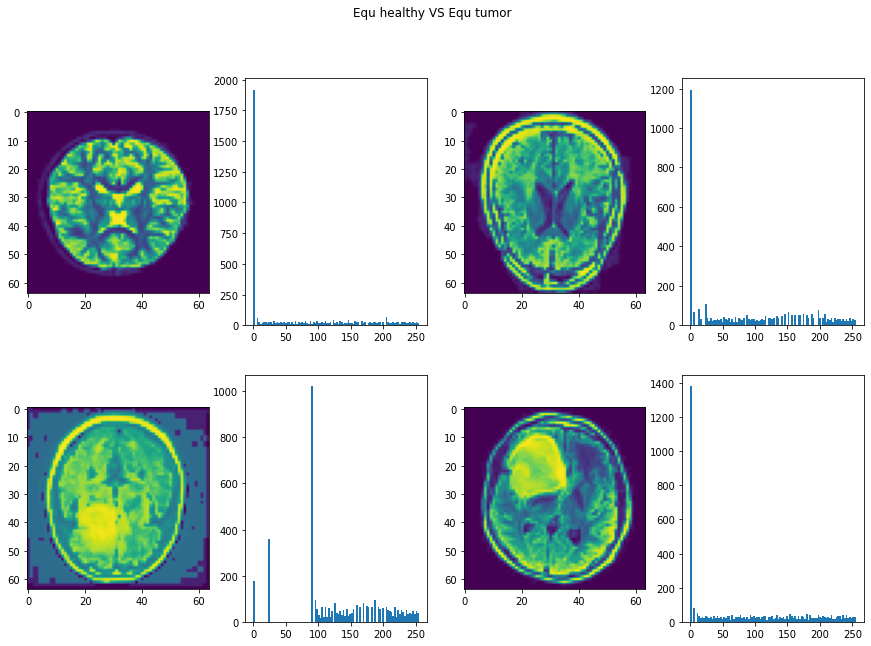

<Figure size 432x288 with 0 Axes>

In [15]:
# Initialise the subplots using number of rows and columns
figure, axis = plt.subplots(2, 4)
#custom layout
figure.set_figheight(10)
figure.set_figwidth(15)

def ploty (row,col,idx):
   
    
    img = cv2.cvtColor(dataset[idx],cv2.COLOR_BGR2LAB)
    b,g,r = cv2.split(img)
    equ = cv2.equalizeHist(b)
    axis[row,col].imshow(equ)
        
    axis[row,col+1].hist(equ.flat, bins=100, range=(0,255))
ploty(0,0,200)
# image from second (affected)
ploty(1,0,2200)
ploty(0,2,600)
ploty(1,2,2600)
figure.suptitle("Equ healthy VS Equ tumor")
plt.show()
plt.savefig('equ.png')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


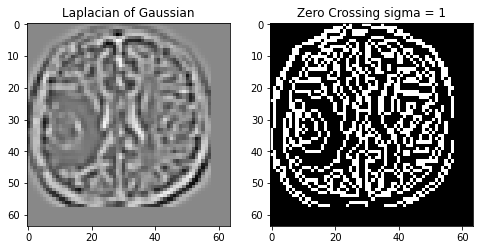

In [16]:
#Edge detection
import argparse
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from skimage import color
from mpl_toolkits.mplot3d import Axes3D

def edgesMarrHildreth(img, sigma,p):

    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1),
                       np.arange(-size/2+1, size/2+1))

    normal = 1 / (2.0 * np.pi * sigma**2)

    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * \
        np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal  # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i, j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            if log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255

    # plotting images
    
    if p==1:
        fig = plt.figure(figsize=(8,8))
        a = fig.add_subplot(1, 2, 1)
        imgplot = plt.imshow(log, cmap='gray')
        a.set_title('Laplacian of Gaussian')
        a = fig.add_subplot(1, 2, 2)
        imgplot = plt.imshow(zero_crossing, cmap='gray')
        string = 'Zero Crossing sigma = '
        string += (str(sigma))
        a.set_title(string)
        plt.show()

    return log, zero_crossing



img = color.rgb2gray(equ)

log, zero_crossing = edgesMarrHildreth(img, 1,1)

In [17]:
#Combining all Preprocessing into a utility function
def process_img(x):
    for i in range(len(x)):
        img = cv2.cvtColor(x[i],cv2.COLOR_BGR2LAB)
        b,g,r = cv2.split(img)
        equ = cv2.equalizeHist(b)
        img = color.rgb2gray(img)

        log, zero_crossing = edgesMarrHildreth(img, 1,0)
        log.resize(64,64,1)
        #print(x[i].shape,log.shape)
        x[i] = log
    
        
        

# Train Test Split and Applying the preprocess function to all the images

In [18]:
x_train, x_test, y_train, y_test=train_test_split(dataset, label, test_size=0.2, random_state=0)

In [19]:
process_img(x_test)
process_img(x_train)


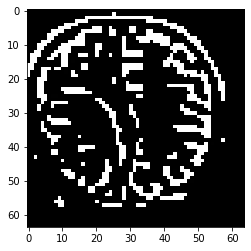

In [24]:
plt.imshow(x_train[10])

In [25]:
"""x_train=normalize(x_train,axis=1)
x_test=normalize(x_test,axis=1)"""

'x_train=normalize(x_train,axis=1)\nx_test=normalize(x_test,axis=1)'

## 3. Building the model

In [26]:
model=Sequential()
# 1st conv2D layer
model.add(Conv2D(32,(3,3),input_shape=(INPUT_SIZE,INPUT_SIZE,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 2nd conv2D layer
model.add(Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# 3rd conv2D layer
model.add(Conv2D(32,(3,3),kernel_initializer='he_uniform'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

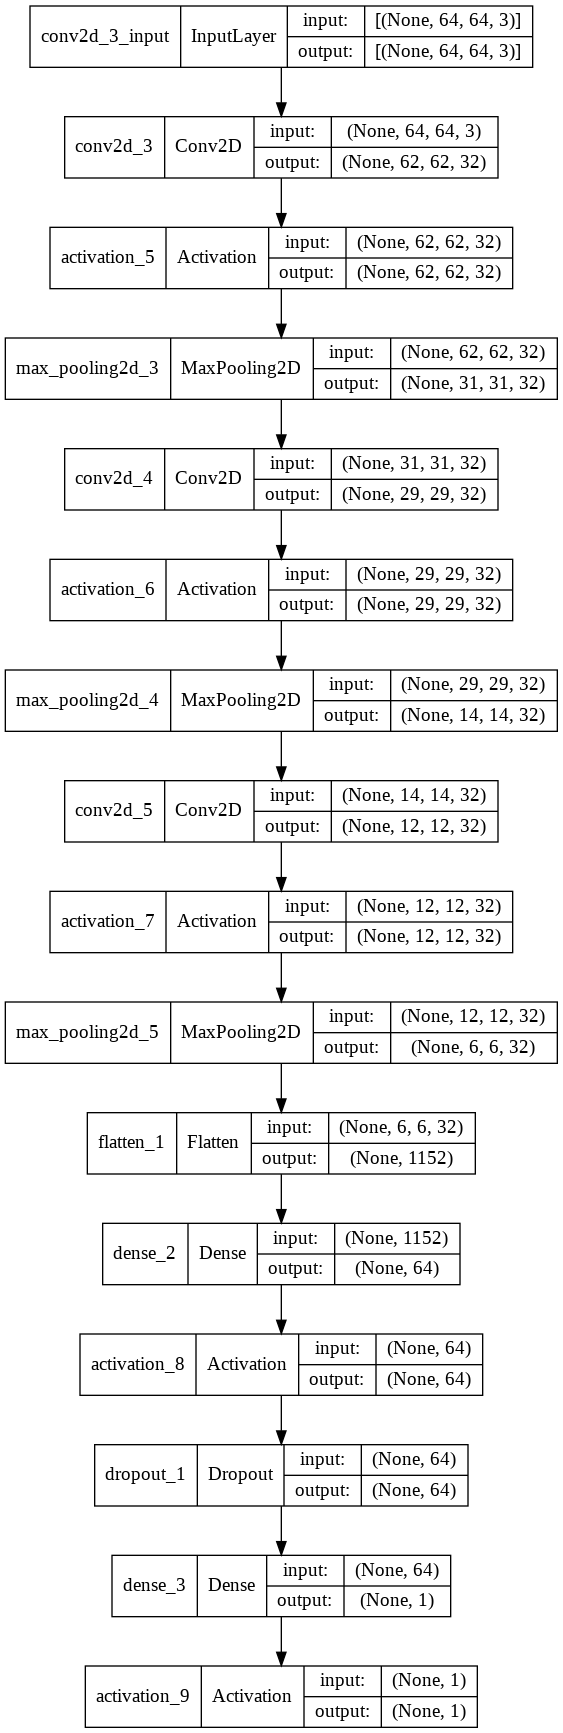

In [27]:
tf.keras.utils.plot_model(model,
                          to_file="model.png",
                          show_shapes=True,
                          expand_nested=True)

In [28]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

    plt.show()


Epoch 1/17
150/150 [==============================] - 13s 80ms/step - loss: 4.0626 - accuracy: 0.6275 - val_loss: 0.5461 - val_accuracy: 0.7033
Epoch 2/17
150/150 [==============================] - 12s 79ms/step - loss: 0.5890 - accuracy: 0.6862 - val_loss: 0.5168 - val_accuracy: 0.7150
Epoch 3/17
150/150 [==============================] - 12s 79ms/step - loss: 0.5073 - accuracy: 0.7292 - val_loss: 0.4583 - val_accuracy: 0.7633
Epoch 4/17
150/150 [==============================] - 12s 80ms/step - loss: 0.4567 - accuracy: 0.7683 - val_loss: 0.3969 - val_accuracy: 0.8150
Epoch 5/17
150/150 [==============================] - 12s 79ms/step - loss: 0.4298 - accuracy: 0.7858 - val_loss: 0.3839 - val_accuracy: 0.8150
Epoch 6/17
150/150 [==============================] - 12s 79ms/step - loss: 0.3899 - accuracy: 0.8062 - val_loss: 0.3435 - val_accuracy: 0.8533
Epoch 7/17
150/150 [==============================] - 12s 80ms/step - loss: 0.3358 - accuracy: 0.8492 - val_loss: 0.3643 - val_accuracy:

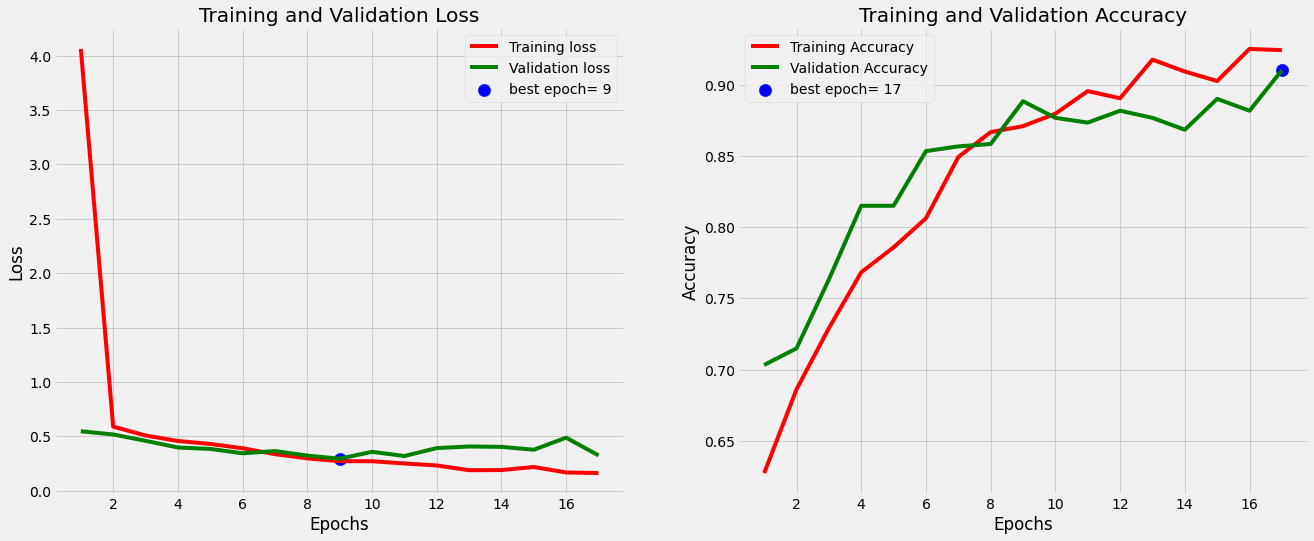

<Figure size 432x288 with 0 Axes>

In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,batch_size=16,verbose=1,epochs=17
          , validation_data=(x_test,y_test),
          shuffle=False)
# plot the history
tr_plot(history,0)
plt.savefig('history.png')
model.save('BrainTumor.h5')